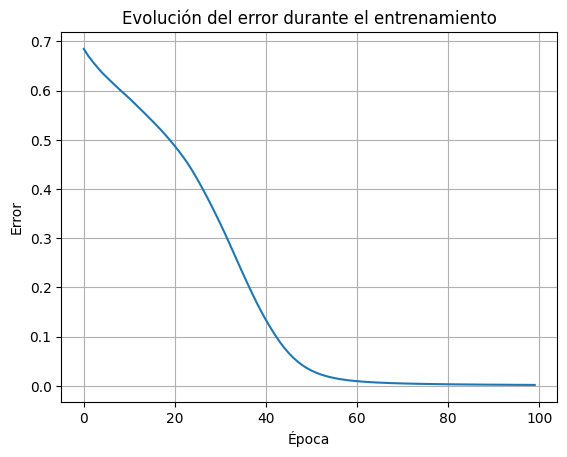

✅ Precisión en datos de prueba: 96.80%
🔻 Pérdida logarítmica (log-loss): 0.0851

📊 Reporte detallado por clase:
Clase 0: Precisión=0.98, Recall=0.99, F1-score=0.98
Clase 1: Precisión=0.40, Recall=0.33, F1-score=0.36
Exactitud global: 0.97
macro avg: Precisión=0.69, Recall=0.66, F1-score=0.67
weighted avg: Precisión=0.97, Recall=0.97, F1-score=0.97


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. CARGAR Y PREPARAR DATOS
print("Paso 1: Cargando datos...")
datos = pd.read_csv("flu_training_data_estado0.csv")

# Mostrar información de los datos
print(f"Dimensiones del dataset: {datos.shape}")
print("Primeras filas del dataset:")
print(datos.head())

# Filtrar clases que tengan al menos 2 ejemplos (necesario para entrenamiento y prueba)
conteo_clases = datos["flu"].value_counts()
print("\nDistribución de clases:")
print(conteo_clases)
clases_validas = conteo_clases[conteo_clases > 1].index
datos = datos[datos["flu"].isin(clases_validas)]

# Separar características (X) y etiquetas (y)
X = datos.drop(columns=["flu"]).values  # Convertir directamente a numpy array
y = datos["flu"].values

# 2. DIVIDIR DATOS EN ENTRENAMIENTO Y PRUEBA
print("\nPaso 2: Dividiendo datos en entrenamiento (80%) y prueba (20%)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=100, shuffle=True
)
print(f"Datos de entrenamiento: {X_train.shape[0]} ejemplos")
print(f"Datos de prueba: {X_test.shape[0]} ejemplos")

# 3. NORMALIZAR DATOS (importante para redes neuronales)
print("\nPaso 3: Normalizando datos...")
escalador = StandardScaler()
X_train = escalador.fit_transform(X_train)
X_test = escalador.transform(X_test)

# Mostrar efecto de la normalización
print("Antes de normalizar (primeros 5 valores):")
print(datos.drop(columns=["flu"]).iloc[0:1, 0:5])
print("Después de normalizar (primeros 5 valores):")
print(X_train[0:1, 0:5])

# 4. DEFINIR UNA RED NEURONAL SIMPLE
print("\nPaso 4: Definiendo la arquitectura de la red neuronal...")

class RedNeuronalSimple:
    def __init__(self, n_entradas, n_ocultas, n_salidas):
        """Inicializa una red neuronal simple con una capa oculta"""
        # Inicializar pesos aleatoriamente con distribución normal
        self.W1 = np.random.randn(n_entradas, n_ocultas) * 0.01
        self.b1 = np.zeros((1, n_ocultas))
        self.W2 = np.random.randn(n_ocultas, n_salidas) * 0.01
        self.b2 = np.zeros((1, n_salidas))
    
    def sigmoid(self, x):
        """Función de activación sigmoid"""
        return 1 / (1 + np.exp(-x))
    
    def softmax(self, x):
        """Función softmax para salida de clasificación"""
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def forward(self, X):
        """Propagación hacia adelante (predicción)"""
        # Primera capa
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)
        
        # Segunda capa (salida)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.softmax(self.z2)
        
        return self.a2
    
    def calcular_perdida(self, y_verdadero, y_pred):
        """Calcula la pérdida de entropía cruzada"""
        m = y_verdadero.shape[0]
        # Convertir y_verdadero a one-hot
        y_one_hot = np.zeros((m, np.max(y_verdadero) + 1))
        y_one_hot[np.arange(m), y_verdadero] = 1
        
        # Entropía cruzada
        log_probs = -np.log(y_pred[np.arange(m), y_verdadero] + 1e-10)
        perdida = np.sum(log_probs) / m
        return perdida
    
    def backward(self, X, y_verdadero):
        """Retropropagación para calcular gradientes"""
        m = X.shape[0]
        
        # Convertir y_verdadero a one-hot
        y_one_hot = np.zeros((m, np.max(y_verdadero) + 1))
        y_one_hot[np.arange(m), y_verdadero] = 1
        
        # Derivada de la pérdida respecto a la salida
        dz2 = self.a2 - y_one_hot
        
        # Derivadas para la capa 2
        dW2 = np.dot(self.a1.T, dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m
        
        # Derivadas para la capa 1
        dz1 = np.dot(dz2, self.W2.T) * (self.a1 * (1 - self.a1))
        dW1 = np.dot(X.T, dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m
        
        return dW1, db1, dW2, db2
    
    def actualizar_parametros(self, dW1, db1, dW2, db2, tasa_aprendizaje):
        """Actualiza los pesos usando descenso de gradiente"""
        self.W1 -= tasa_aprendizaje * dW1
        self.b1 -= tasa_aprendizaje * db1
        self.W2 -= tasa_aprendizaje * dW2
        self.b2 -= tasa_aprendizaje * db2
    
    def entrenar(self, X, y, tasa_aprendizaje, epocas, verbose=True):
        """Entrena la red neuronal"""
        historial_perdida = []
        
        for epoca in range(epocas):
            # Forward pass
            y_pred = self.forward(X)
            
            # Calcular pérdida
            perdida = self.calcular_perdida(y, y_pred)
            historial_perdida.append(perdida)
            
            # Backward pass
            dW1, db1, dW2, db2 = self.backward(X, y)
            
            # Actualizar parámetros
            self.actualizar_parametros(dW1, db1, dW2, db2, tasa_aprendizaje)
            
            # Mostrar progreso
            if verbose and epoca % 10 == 0:
                print(f"Epoca {epoca}/{epocas} | Pérdida: {perdida:.4f}")
        
        return historial_perdida
    
    def predecir(self, X):
        """Realiza predicciones"""
        probabilidades = self.forward(X)
        return np.argmax(probabilidades, axis=1)
    
    def evaluar(self, X, y):
        """Evalúa la precisión del modelo"""
        predicciones = self.predecir(X)
        precision = np.mean(predicciones == y)
        return precision

# 5. CREAR Y ENTRENAR LA RED NEURONAL
print("\nPaso 5: Creando y entrenando la red neuronal...")
n_entradas = X_train.shape[1]
n_ocultas = 16  # Número de neuronas en la capa oculta
n_salidas = len(np.unique(y_train))  # Número de clases

print(f"Arquitectura de la red: {n_entradas} entradas → {n_ocultas} neuronas ocultas → {n_salidas} salidas")

# Crear la red
red = RedNeuronalSimple(n_entradas, n_ocultas, n_salidas)

# Entrenar la red
print("\nEntrenando la red neuronal...")
tasa_aprendizaje = 0.01
epocas = 100
historial_perdida = red.entrenar(X_train, y_train, tasa_aprendizaje, epocas)

# 6. VISUALIZAR ENTRENAMIENTO
print("\nPaso 6: Visualizando el progreso del entrenamiento...")
plt.figure(figsize=(10, 6))
plt.plot(range(epocas), historial_perdida)
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Entropía Cruzada)')
plt.grid(True)
plt.show()

# 7. EVALUAR EL MODELO
print("\nPaso 7: Evaluando el modelo...")
precision_train = red.evaluar(X_train, y_train)
precision_test = red.evaluar(X_test, y_test)

print(f"Precisión en datos de entrenamiento: {precision_train*100:.2f}%")
print(f"Precisión en datos de prueba: {precision_test*100:.2f}%")

# 8. HACER PREDICCIONES CON ALGUNOS EJEMPLOS
print("\nPaso 8: Realizando predicciones con ejemplos de prueba...")
indices_muestra = np.random.choice(len(X_test), size=5, replace=False)
X_muestra = X_test[indices_muestra]
y_verdadero = y_test[indices_muestra]

probabilidades = red.forward(X_muestra)
predicciones = red.predecir(X_muestra)

print("\nResultados de predicción:")
print("Índice | Clase Real | Predicción | Probabilidad")
print("------------------------------------------")
for i in range(len(indices_muestra)):
    prob = probabilidades[i, predicciones[i]]
    print(f"{indices_muestra[i]:6d} | {y_verdadero[i]:10d} | {predicciones[i]:10d} | {prob:.4f}")

print("\n¡Demostración completada!")

In [ ]:
# Graficar función de costo
plt.plot(errores)
plt.title("Evolución del error durante el entrenamiento")
plt.xlabel("Época")
plt.ylabel("Error")
plt.grid()
plt.show()

In [ ]:
# Mostrar resultados en español
print(f"✅ Precisión en datos de prueba: {precision*100:.2f}%")
print(f"🔻 Pérdida logarítmica (log-loss): {perdida_log:.4f}\n")
print("📊 Reporte detallado por clase:")

for clase, metricas in reporte.items():
    if clase == 'accuracy':
        print(f"Exactitud global: {metricas:.2f}")
    elif clase in ['macro avg', 'weighted avg']:
        print(f"{clase}: Precisión={metricas['precision']:.2f}, Recall={metricas['recall']:.2f}, F1-score={metricas['f1-score']:.2f}")
    elif clase.isdigit():
        print(f"Clase {clase}: Precisión={metricas['precision']:.2f}, Recall={metricas['recall']:.2f}, F1-score={metricas['f1-score']:.2f}")